# 3. Xception
Our third attempt will be to use a pretrained model Xception. This model is bigger than MobileNetV2, but it should be also trainable in reasonable time.

In [1]:
import tensorflow as tf

from tensorflow import keras
from keras.models import Sequential 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception, preprocess_input
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
import numpy as np

In [2]:
sys_details = tf.sysconfig.get_build_info()
cuda_version = sys_details["cuda_version"]
print('Cuda vesion:', cuda_version)
cudnn_version = sys_details["cudnn_version"]  
print('Cudnn vesion:', cudnn_version)

Cuda vesion: 11.2
Cudnn vesion: 8


## Preparation and model creation
Uncomment the configuration that you would like to train.

In [3]:
_train_dir = 'resized128/train'
_test_dir = 'resized128/test'
_img_width, _img_height = 128,128 
_batch_size = 64
_weights_name = 'maskedfaces128_xception.h5'

In [4]:
# _train_dir = 'resized224/train'
# _test_dir = 'resized224/test'
# _img_width, _img_height = 224,224 
# _batch_size = 64
# _weights_name = 'maskedfaces224_xception.h5'

Note, that we using a preprocessing function argument, that contains preprocess_input function for Xception.

In [5]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.15) # set validation split

train_generator = train_datagen.flow_from_directory(
    _train_dir,
    target_size=(_img_height, _img_width),
    batch_size=_batch_size,
    class_mode='binary',
    subset='training') # set as training data

valid_generator = train_datagen.flow_from_directory(
    _train_dir, # same directory as training data
    target_size=(_img_height, _img_width),
    batch_size=_batch_size,
    class_mode='binary',
    subset='validation') # set as validation data

Found 96658 images belonging to 2 classes.
Found 17057 images belonging to 2 classes.


In [6]:
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255)

test_generator = train_datagen.flow_from_directory(
    _test_dir,
    target_size=(_img_height, _img_width),
    batch_size=_batch_size,
    class_mode='binary')

Found 20067 images belonging to 2 classes.


In this model we are adding a Xception model pretrained on the imagenet dataset. As didn't allow learning in previous model (and it didn't help), we will allow learning of all layers. After the Xception model, we will add one 2048 dense layer with relu activation function followed by a dropout layer. As before we add average pooling layer and after the Xception and in the end ouput dense layer. We are using Adam optimizer with 0.001 learning rate and accuracy metric.

In [7]:
model = Sequential()
model.add(Xception(include_top = False, weights="imagenet", input_shape=(_img_width, _img_height, 3)))
model.add(GlobalAveragePooling2D())

model.add(Dense(2048, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.15))

model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001),  metrics=['accuracy'])
model.summary()

2021-12-29 16:00:21.325331: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-29 16:00:21.804160: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9705 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:0c:00.0, compute capability: 6.1


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 25,059,881
Trainable params: 25,005,353
Non-trainable params: 54,528
_______________________________________

## Training the model
We have also added a checkpoint save weights with the best validation loss. You can also [skip](#skip) the training.

In [8]:
checkpointer = ModelCheckpoint(filepath=_weights_name, verbose=1, save_best_only=True)

We will train the model for 15 epochs.

In [9]:
hist = model.fit(train_generator, validation_data = valid_generator, epochs=15, callbacks=[checkpointer], verbose=True)

Epoch 1/15


2021-12-29 16:00:33.313383: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204


1511/1511 [==============================] - ETA: 0s - loss: 0.0293 - accuracy: 0.9896
Epoch 00001: val_loss improved from inf to 0.00242, saving model to maskedfaces128_xception.h5


/home/rbelanec/Documents/ml-project/ml/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1511/1511 [==============================] - 416s 271ms/step - loss: 0.0293 - accuracy: 0.9896 - val_loss: 0.0024 - val_accuracy: 0.9992
Epoch 2/15
1511/1511 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 0.9989
Epoch 00002: val_loss did not improve from 0.00242
1511/1511 [==============================] - 396s 262ms/step - loss: 0.0038 - accuracy: 0.9989 - val_loss: 0.0164 - val_accuracy: 0.9960
Epoch 3/15
1511/1511 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.9990
Epoch 00003: val_loss improved from 0.00242 to 0.00217, saving model to maskedfaces128_xception.h5
1511/1511 [==============================] - 399s 264ms/step - loss: 0.0035 - accuracy: 0.9990 - val_loss: 0.0022 - val_accuracy: 0.9993
Epoch 4/15
1511/1511 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.9992
Epoch 00004: val_loss improved from 0.00217 to 0.00185, saving model to maskedfaces128_xception.h5
1511/1511 [==============================] - 4

Now we will plot the training history and evaluate our model on test data.

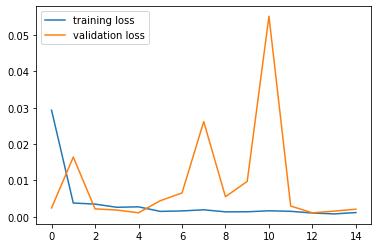

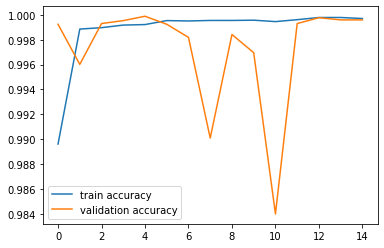

In [10]:
plt.figure()
plt.plot(hist.history['loss'], label='training loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.legend(loc='best')

plt.figure()
plt.plot(hist.history['accuracy'], label='train accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='best')
plt.show()

<a id='skip'></a> If you want to skip the training, just uncomment the first or the second cell under this text. But don't forget to recompile the model with desired (128/224) configuration.

In [11]:
# !wget https://data.belanec.eu/maskedface/weights/maskedfaces128_xception.h5
# _weights_name = 'maskedfaces128_xception.h5'

In [12]:
# !wget https://data.belanec.eu/maskedface/weights/maskedfaces224_xception.h5
# _weights_name = 'maskedfaces224_xception.h5'

In [13]:
model.load_weights(_weights_name)

In [14]:
train_score = model.evaluate(train_generator)
print("\n\ntrain loss: {} | train acc: {}\n".format(train_score[0], train_score[1]))

test_score = model.evaluate(test_generator)
print("\n\ntest loss: {} | test acc: {}".format(test_score[0], test_score[1]))

1511/1511 [==============================] - 325s 215ms/step - loss: 2.7630e-04 - accuracy: 0.9999


train loss: 0.00027630102704279125 | train acc: 0.9999068975448608

314/314 [==============================] - 74s 235ms/step - loss: 3.3284e-04 - accuracy: 1.0000


test loss: 0.0003328374295961112 | test acc: 0.9999501705169678


In [15]:
model_predictions = model.predict(test_generator)

In [16]:
preds = np.array(model_predictions > 0.5).astype(int).T[0]
labels = np.array(test_generator.classes)

f1 = f1_score(labels, preds)
print('F1 score: ', f1)

F1 score:  0.5011203505452373


## Conclusion

Our model with pretrained Xception model with disabled learning ended up with much better accuracy. The F1 score is still poor. We will continue in [next](https://github.com/Wicwik/ml-project/blob/master/maskedfaces_no_pretrained.ipynb) notebook, with our final custom network. The training of this model was around 6 minutes per epoch on 128x128 images and around 20 minutes per epoch on 224x224 images.

### 224x224 images
Our Xception model with 224x224 images ended up with results:
- train loss: 0.0004
- train accuracy: 0.99
- test loss: 0.0002
- test accuracy: 0.99
- F1 score: 0.51

### 128x128 images
Our Xception model with 128x128 images ended up with results:
- train loss: 0.0003
- train accuracy: 0.99
- test loss: 0.0003
- test accuracy: 0.99
- F1 score: 0.5